# 1. To Start!

We first import the packages that we will be using. 

We need pandas to work on our data, matplotlib pyplot for visualizations, numpy for array calculations, and finally networkx for all our graph networks.

In [6]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from numba import njit
import random
import pandas as pd
import BowenProjectFunctions as bpf

Next, we grab the static gtfs rail text files and read them into dataframes.

In [7]:
trips = pd.read_csv('../gtfs_rail/trips.txt')
stops = pd.read_csv('../gtfs_rail/stops.txt')

# 2. Cleaning the Data

Ok, so we really need to clean this data up. We remove all stops that are not part of the LA Metro rail lines (ie fake stop data) and we only want the main stop for each station. We found simple patterns in the GTFS data and were able to exploit them in order to clean the data very efficiently.

In [8]:
stops = stops[stops["stop_id"].str[:3] < "810"]
stops = stops[stops["location_type"] == 0]

# 3. Creating the Graph

Now we can use networkx package to create graph objects. We will be using the graph object to create calculations. We will create a simple graph of our rail network for now. There is a lot of hardcoding of a couple connections. 



In [9]:
# Creating our graph
rail_network = nx.Graph()

# Node List
# Get all stop IDs and put in list
NL = stops["stop_id"].tolist()
# Cast all IDs to int type
NL = [int(i) for i in NL]
# Add node list NL as nodes to our graph
rail_network.add_nodes_from(NL)

# Edges List
# Empty list
EL = []
# Loop through our sorted stops
for i in range(len(stops)-1):
    # Grab the IDs of each stop and consecutive stop
    stop_id_1 = int(stops["stop_id"].iloc[[i]])
    stop_id_2 = int(stops["stop_id"].iloc[[i+1]])
    
    # Append the stop tuple if they are next to each other on the line
    if stop_id_1+1 == stop_id_2:
        EL.append((stop_id_1, stop_id_2))
        
# We find the intersection stops
intersection1 = stops[stops["stop_name"].str[:10] == "7th Street"]["stop_code"].tolist()
intersection1 = bpf.to_int(intersection1)
intersection2 = stops[stops["stop_name"].str[:10] == "Willowbroo"]["stop_code"].tolist()
intersection2 = bpf.to_int(intersection2)
intersection3 = stops[stops["stop_name"].str[:10] == "Union Stat"]["stop_code"].tolist()
intersection3 = bpf.to_int(intersection3)
intersection4 = stops[stops["stop_name"].str[:10] == "Expo / Cre"]["stop_code"].tolist()
intersection4 = bpf.to_int(intersection4)
# Append the intersection stops
EL.append((intersection1[0], intersection1[1]))
EL.append((intersection2[0], intersection2[1]))
EL.append((intersection3[0], intersection3[1]))
EL.append((intersection4[0], intersection4[1]))

# Extra missed connections
EL.append((80154, 80105))
# Add edge list to graph
rail_network.add_edges_from(EL)

# 4. Visualization Time!

Let's see what our graph looks like.


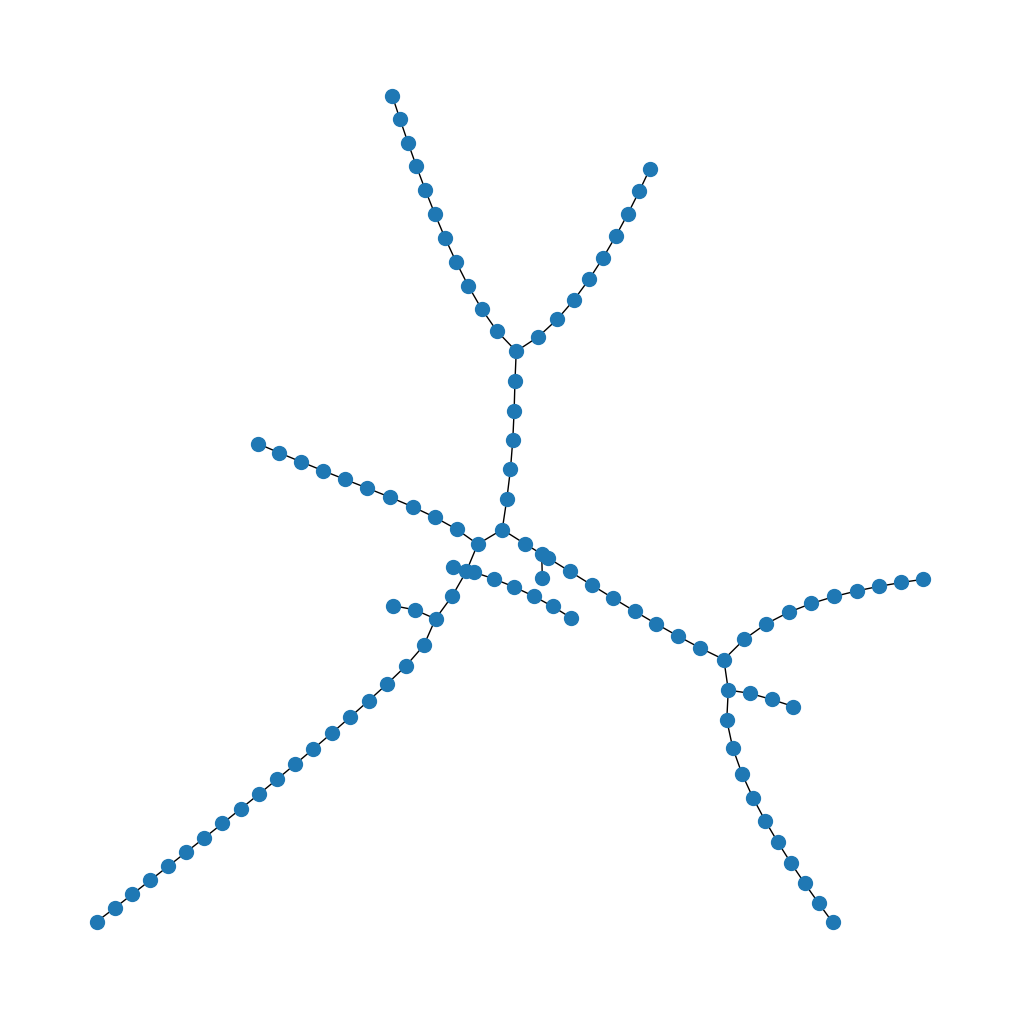

In [10]:
# Set figure size
fig = plt.figure(figsize = (10,10))
# We use Kamada-Kawai positioning algorithm to plot the nodes of the graph
nx.draw_kamada_kawai(rail_network, with_labels=False, node_size=100)

# 5. Analysis of Simple Graph

We can proceed to do some simple mathematical analysis such as centrality and modularity on our graph. 

We use Katz centrality in this case, and visualize them on our rail network:

{80214: Text(-0.20079330718192953, -0.10754573122354516, '80214'),
 80212: Text(-0.1281620106999731, -0.009949115587035507, '80212'),
 80210: Text(-0.14992560086197476, 0.07625760865917434, '80210'),
 80123: Text(-0.03246334170100554, 0.1391720737070623, '80123'),
 80121: Text(0.011356986992349933, 0.046159705959776295, '80121')}

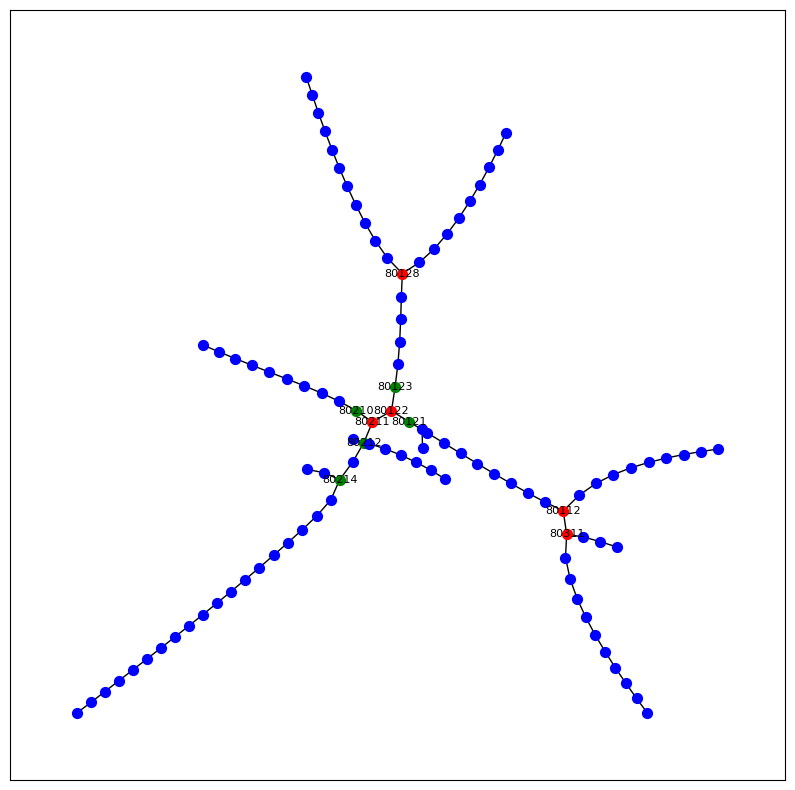

In [11]:
# Get the centrality of the nodes
k_centralities = nx.katz_centrality(rail_network, max_iter = 1000)
# Sort the nodes based on their centrality measure
sorted_k_centralities = sorted(k_centralities.items(), key=lambda x:x[1], reverse=True)

# Get the top 5 stations
high_centrality = [station for station,centrality in sorted_k_centralities][:5]
labels_high_centrality = {}    
for node in high_centrality:
    #set the node name as the key and the label as its value 
    labels_high_centrality[node] = node
# Next highest 5
next_high_centrality = [station for station,centrality in sorted_k_centralities][5:10]
labels_next_high_centrality = {}    
for node in next_high_centrality:
    #set the node name as the key and the label as its value 
    labels_next_high_centrality[node] = node
# remaining stations
remaining_nodes = list(set(rail_network.nodes()) - set(high_centrality) - set(next_high_centrality))

# Plot the graph with the stations 
fig = plt.figure(figsize=(10, 10))
layout = nx.kamada_kawai_layout(rail_network)
nx.draw_networkx_nodes(rail_network, layout, labels_high_centrality, node_color='red', node_size=50)
nx.draw_networkx_nodes(rail_network, layout, labels_next_high_centrality, node_color='green', node_size=50)
nx.draw_networkx_nodes(rail_network, layout, nodelist=remaining_nodes, node_color='blue', node_size=50)
nx.draw_networkx_edges(rail_network, layout)
nx.draw_networkx_labels(rail_network, layout, labels_high_centrality, font_size=8)
nx.draw_networkx_labels(rail_network, layout, labels_next_high_centrality, font_size=8)

We can also see how modular our network is so far:

In [ ]:
# Make list of stop IDs
stop_id_list = stops["stop_id"].tolist()
stop_id_list = bpf.to_int(stop_id_list)

# Create groups for each of our routes
route_A = bpf.route_id(1)
route_B = bpf.route_id(2)
route_C = bpf.route_id(3)
route_E = bpf.route_id(4)
route_K = bpf.route_id(7)
route_D = bpf.route_id(5)

# A list of all our groups!
route_groups = [route_A, route_B, route_C, route_E, route_K, route_D]

# Using our networkx function
nx.community.modularity(rail_network, route_groups)

Our graph is really quite modular. This means that rail lines do not intersect with each other all that often in LA.

# 6. Implementing Methods from Research Papers

Let's figure out most influential spreaders with a recursive formula over target nodes. 

First, we must decide which nodes are the most important to us. I created two lists of nodes, first with highest ridership and the second which are most important for concerts, large venues, and sports games. 

In [ ]:
# Busiest Stations
print(f"7th Street / Metro - 80122, index {NL.index(80122)}")
print(f"Union Station - 80214, index {NL.index(80214)}")
print(f"Culver City Station - 80132, index {NL.index(80132)}")
print(f"North Hollywood Station - 80201, index {NL.index(80201)}")
print(f"Wilshire / Vermont - 80209, index {NL.index(80209)}")
busy_station_ids = [80122, 80214, 80132, 80201, 80209]

# Concert/Stadium cluster of nodes (Crypto arena, stadiums near USC, dodger stadium)
print(f"Pico - 80121, index {NL.index(80121)}")
print(f"Expo Park / USC - 80125, index {NL.index(80125)}")
print(f"Union Station - 80214, index {NL.index(80214)}")
Destination_station_ids = [80121, 80125, 80214]

We looked at 3 papers that aided the creation of our method:
- https://www.nature.com/articles/srep38865
- https://www.sciencedirect.com/science/article/pii/S0167278923000313?via%3Dihub
- https://www.frontiersin.org/articles/10.3389/fphy.2021.806259/full

We can look at the results of our top 5 busiest stations first:

In [ ]:
# First for 5 busiest stations

# get f
f = np.zeros((1,len(NL)))
busy_station_indices = bpf.station_id_to_index(busy_station_ids, NL)
for i in busy_station_indices:
    f[0][i[1]] = 1
    
# Get adjacency matrix
A_busy = nx.adjacency_matrix(rail_network)
A_busy = A_busy.toarray()

# epsilon
epsilon = 0.1

# Calculate
bpf.get_ranked_stations(bpf.rlp(f, A_busy, epsilon, 3). NL)